In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
from tqdm.notebook import tqdm
from pathlib import Path
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import plot_importance


# Načítání dat

In [217]:
data = pd.read_csv("C:/Users/matej/Desktop/MFF UK/8. semester/Data Science 2/Zadanie 1/2024_DS2_HW1_data_train.csv", sep = ',', decimal = '.', index_col = 'Booking_ID')
test = pd.read_csv("C:/Users/matej/Desktop/MFF UK/8. semester/Data Science 2/Zadanie 1/2024_DS2_HW1_data_test.csv", sep = ',', decimal = '.', index_col = 'Booking_ID')

In [3]:
# set width of Jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# set some visual properties of displaying pandas DataFrame
pd.options.display.max_columns=200
pd.options.display.max_rows=200

# Overview of the data

In [21]:
data

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
Booking_ID,,,,,,,,,,,,,,,,,,
INN10204,NaN,NaN,NaN,2.0,Meal Plan 2,NaN,Room_Type 6,NaN,2018.0,9.0,NaN,Online,0.0,0.0,NaN,NaN,1.0,0.0
INN20020,NaN,NaN,NaN,2.0,Meal Plan 1,NaN,NaN,NaN,NaN,12.0,NaN,Online,0.0,0.0,0.0,NaN,NaN,0.0
INN16435,1.0,NaN,NaN,2.0,NaN,0.0,Room_Type 1,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0
INN07143,3.0,NaN,NaN,3.0,NaN,NaN,NaN,100.0,2018.0,5.0,NaN,Online,0.0,0.0,NaN,NaN,2.0,0.0
INN20511,1.0,0.0,1.0,1.0,Meal Plan 1,0.0,NaN,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,0.0,150.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INN16851,2.0,NaN,NaN,NaN,Meal Plan 1,NaN,NaN,43.0,2017.0,12.0,26.0,Offline,NaN,0.0,0.0,NaN,2.0,0.0
INN06266,1.0,NaN,NaN,2.0,Meal Plan 2,0.0,Room_Type 1,102.0,2017.0,10.0,NaN,Online,NaN,0.0,NaN,80.0,NaN,1.0
INN11285,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2018.0,5.0,NaN,Corporate,0.0,0.0,0.0,NaN,1.0,0.0


In [22]:
test

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
Booking_ID,,,,,,,,,,,,,,,,,
INN04969,2.0,NaN,1.0,0.0,Meal Plan 1,NaN,NaN,NaN,2017.0,8.0,23.0,NaN,NaN,0.0,NaN,NaN,3.0
INN34541,2.0,0.0,NaN,2.0,Meal Plan 1,0.0,NaN,NaN,2018.0,2.0,NaN,Offline,NaN,0.0,0.0,NaN,NaN
INN36109,2.0,NaN,NaN,2.0,Meal Plan 1,0.0,NaN,NaN,2018.0,12.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
INN01554,2.0,NaN,0.0,3.0,NaN,0.0,NaN,NaN,2018.0,6.0,21.0,Online,NaN,0.0,0.0,NaN,0.0
INN24975,2.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2018.0,9.0,NaN,NaN,NaN,0.0,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INN29523,1.0,NaN,NaN,2.0,Meal Plan 2,0.0,Room_Type 1,39.0,2017.0,8.0,NaN,Offline,NaN,0.0,NaN,87.00,NaN
INN25061,2.0,NaN,1.0,NaN,Not Selected,0.0,NaN,NaN,2018.0,6.0,NaN,Online,0.0,0.0,NaN,NaN,NaN
INN08475,2.0,NaN,NaN,NaN,NaN,NaN,NaN,308.0,2018.0,11.0,NaN,Online,NaN,0.0,0.0,78.30,NaN


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32647 entries, INN10204 to INN15796
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          28231 non-null  float64
 1   no_of_children                        5043 non-null   float64
 2   no_of_weekend_nights                  7729 non-null   float64
 3   no_of_week_nights                     24287 non-null  float64
 4   type_of_meal_plan                     16544 non-null  object 
 5   required_car_parking_space            17863 non-null  float64
 6   room_type_reserved                    11360 non-null  object 
 7   lead_time                             6935 non-null   float64
 8   arrival_year                          29654 non-null  float64
 9   arrival_month                         31740 non-null  float64
 10  arrival_date                          5457 non-null   float64
 11  market_seg

In [150]:
print(f'Number of rows:   {data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {data.shape[1]:,}'.replace(',', ' '))

Number of rows:   32 647
Number of unique indexes:   32 647
Number of columns:   18


In [218]:
data.rename(columns = {'booking_status':'TARGET'}, inplace = True)
data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,TARGET
Booking_ID,,,,,,,,,,,,,,,,,,
INN10204,NaN,NaN,NaN,2.0,Meal Plan 2,NaN,Room_Type 6,NaN,2018.0,9.0,NaN,Online,0.0,0.0,NaN,NaN,1.0,0.0
INN20020,NaN,NaN,NaN,2.0,Meal Plan 1,NaN,NaN,NaN,NaN,12.0,NaN,Online,0.0,0.0,0.0,NaN,NaN,0.0
INN16435,1.0,NaN,NaN,2.0,NaN,0.0,Room_Type 1,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0
INN07143,3.0,NaN,NaN,3.0,NaN,NaN,NaN,100.0,2018.0,5.0,NaN,Online,0.0,0.0,NaN,NaN,2.0,0.0
INN20511,1.0,0.0,1.0,1.0,Meal Plan 1,0.0,NaN,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,0.0,150.0,NaN,1.0


In [219]:
col_target = "TARGET"
col_month = "arrival_month"

In [220]:
# define list of predictors
cols_pred = list(data.columns[0:-1])

# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']

print('Numerical predictors:')
print('---------------------')
print(data[cols_pred_num].dtypes)
print()
print('Categorical predictors:')
print('-----------------------')
print(data[cols_pred_cat].dtypes)

Numerical predictors:
---------------------
no_of_adults                            float64
no_of_children                          float64
no_of_weekend_nights                    float64
no_of_week_nights                       float64
required_car_parking_space              float64
lead_time                               float64
arrival_year                            float64
arrival_month                           float64
arrival_date                            float64
repeated_guest                          float64
no_of_previous_cancellations            float64
no_of_previous_bookings_not_canceled    float64
avg_price_per_room                      float64
no_of_special_requests                  float64
dtype: object

Categorical predictors:
-----------------------
type_of_meal_plan      object
room_type_reserved     object
market_segment_type    object
dtype: object


In [154]:
len(cols_pred),cols_pred

(17,
 ['no_of_adults',
  'no_of_children',
  'no_of_weekend_nights',
  'no_of_week_nights',
  'type_of_meal_plan',
  'required_car_parking_space',
  'room_type_reserved',
  'lead_time',
  'arrival_year',
  'arrival_month',
  'arrival_date',
  'market_segment_type',
  'repeated_guest',
  'no_of_previous_cancellations',
  'no_of_previous_bookings_not_canceled',
  'avg_price_per_room',
  'no_of_special_requests'])

In [221]:
data.TARGET.value_counts(dropna=False)

TARGET
0.0    21774
1.0    10521
NaN      352
Name: count, dtype: int64

In [222]:
data = data.dropna(subset=["TARGET"])

In [223]:
data.drop(data.loc[:,list((100*(data.isnull().sum()/len(data.index))>98))].columns)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,TARGET
Booking_ID,,,,,,,,,,,,,,,,,,
INN10204,NaN,NaN,NaN,2.0,Meal Plan 2,NaN,Room_Type 6,NaN,2018.0,9.0,NaN,Online,0.0,0.0,NaN,NaN,1.0,0.0
INN20020,NaN,NaN,NaN,2.0,Meal Plan 1,NaN,NaN,NaN,NaN,12.0,NaN,Online,0.0,0.0,0.0,NaN,NaN,0.0
INN16435,1.0,NaN,NaN,2.0,NaN,0.0,Room_Type 1,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0
INN07143,3.0,NaN,NaN,3.0,NaN,NaN,NaN,100.0,2018.0,5.0,NaN,Online,0.0,0.0,NaN,NaN,2.0,0.0
INN20511,1.0,0.0,1.0,1.0,Meal Plan 1,0.0,NaN,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,0.0,150.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INN16851,2.0,NaN,NaN,NaN,Meal Plan 1,NaN,NaN,43.0,2017.0,12.0,26.0,Offline,NaN,0.0,0.0,NaN,2.0,0.0
INN06266,1.0,NaN,NaN,2.0,Meal Plan 2,0.0,Room_Type 1,102.0,2017.0,10.0,NaN,Online,NaN,0.0,NaN,80.0,NaN,1.0
INN11285,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2018.0,5.0,NaN,Corporate,0.0,0.0,0.0,NaN,1.0,0.0


In [224]:
data['sample'] = 'default'

# use train_test_split to split the intime into train and rest (don't forget seed)
data_train, data_rest = train_test_split(data, test_size=0.4, random_state = 12)
data.loc[data_train.index, 'sample'] = 'train'
# use train_test_split to split the rest into valid and test (don't forget seed)
data_valid, data_test = train_test_split(data_rest, test_size=0.5, random_state = 12)
data.loc[data_valid.index, 'sample'] = 'valid'
data.loc[data_test.index, 'sample'] = 'test'

## Plotting the cancellations per month

In [159]:
def default_rate_in_time_per_sample(dt, col_target, col_month, col_sample):
    # group by over month and sample
    dt_grp = dt.groupby([col_month, col_sample]).agg(
        def_rt = (col_target, 'mean')
    ).reset_index()
    
    # pivot sample values to columns
    dt_grp_pivot = dt_grp.pivot(index = col_month, columns = col_sample, values = 'def_rt')

    # plot default rate in time
    lines = plt.plot(range(len(dt_grp_pivot)), dt_grp_pivot, marker = 'o')
    plt.xticks(range(len(dt_grp_pivot)), dt_grp_pivot.index, rotation = 90)
    # set legend
    plt.legend(iter(lines), tuple(dt_grp_pivot.columns), loc='best', bbox_to_anchor=(1.05, 1))
    
    plt.ylim([0, 1])
    plt.ylabel('default rate', loc='top')
    plt.xlabel('month', loc='right')
    
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray') 
    
    plt.show()

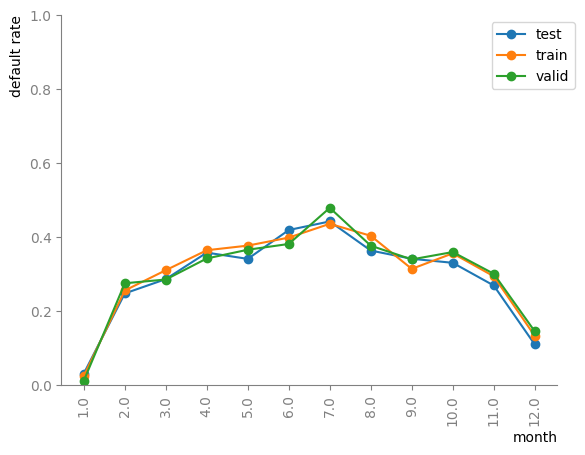

In [83]:
default_rate_in_time_per_sample(data, col_target, col_month, 'sample')

In [225]:
train_mask = (data['sample'] == 'train')
valid_mask = (data['sample'] == 'valid') 
test_mask = (data['sample'] == 'test')

In [226]:
# find columns with infinity values
cols_with_inf = []
for col in cols_pred_num:
    if np.any(np.isinf(data[col])):
        cols_with_inf.append(col)
        print(f'Column {col} includes infinity values.')

# find columns with negative infinity values
cols_with_neginf = []
for col in cols_pred_num:
    if np.any(np.isneginf(data[col])):
        cols_with_neginf.append(col)
        print(f'Column {col} includes negative infinity values.')

In [227]:
# replace infinity values
for col in cols_with_inf:
    data[col] = data[col].replace(np.inf, 9999999)

In [228]:
def mean_target_encoding(dt, predictor, target, alpha = 0.01):
    total_cnt = len(dt)
    total_dr = np.mean(dt[target])
    dt_grp = dt.groupby(predictor).agg(
        categ_dr = (target, 'mean'),
        categ_cnt = (target, len)
    )
    
    dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
    dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_dr'] + alpha * total_dr) / (dt_grp['categ_freq'] + alpha)
    
    return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

In [229]:
total_dr = np.mean(data[train_mask][col_target])
MTEdummies={}

# encode categorical predictors
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 0:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )
        MTEdummies[pred] = new_vals
        
        additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_dr

        data['MTE_' + pred] = data[pred].map(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/3 [00:00<?, ?it/s]

In [230]:
cols_pred

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'required_car_parking_space',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'MTE_type_of_meal_plan',
 'MTE_room_type_reserved',
 'MTE_market_segment_type']

In [231]:
#total_dr = np.mean(data_test[train_mask][col_target])

# encode categorical predictors
for pred in tqdm(cols_pred_cat):
    if len(test[pred].unique()) < 0:
        dummies = pd.get_dummies(
            test[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if test[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in test.columns:
                del test[d]
                
        test = test.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = MTEdummies[pred]

        additional_values = set(test[test[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_dr

        test['MTE_' + pred] = test[pred].map(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/3 [00:00<?, ?it/s]

In [92]:
# set best parameters to be used in XGBoost
params = {    
    'max_depth': 4,
    
    'objective': 'binary:logistic',
    'eval_metric': ['auc'],
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10
)

[0]	train-auc:0.70896	valid-auc:0.70086
[1]	train-auc:0.74298	valid-auc:0.73440
[2]	train-auc:0.75825	valid-auc:0.75413
[3]	train-auc:0.76795	valid-auc:0.76318
[4]	train-auc:0.77516	valid-auc:0.76882
[5]	train-auc:0.78349	valid-auc:0.77789
[6]	train-auc:0.78574	valid-auc:0.77990
[7]	train-auc:0.78985	valid-auc:0.78316
[8]	train-auc:0.79269	valid-auc:0.78575
[9]	train-auc:0.79447	valid-auc:0.78778
[10]	train-auc:0.79750	valid-auc:0.79025
[11]	train-auc:0.79762	valid-auc:0.79081
[12]	train-auc:0.79944	valid-auc:0.79232
[13]	train-auc:0.80143	valid-auc:0.79384
[14]	train-auc:0.80237	valid-auc:0.79477
[15]	train-auc:0.80329	valid-auc:0.79550
[16]	train-auc:0.80405	valid-auc:0.79581
[17]	train-auc:0.80519	valid-auc:0.79606
[18]	train-auc:0.80538	valid-auc:0.79631
[19]	train-auc:0.80579	valid-auc:0.79661
[20]	train-auc:0.80629	valid-auc:0.79719
[21]	train-auc:0.80796	valid-auc:0.79909
[22]	train-auc:0.80823	valid-auc:0.79927
[23]	train-auc:0.80872	valid-auc:0.79955
[24]	train-auc:0.80898	val

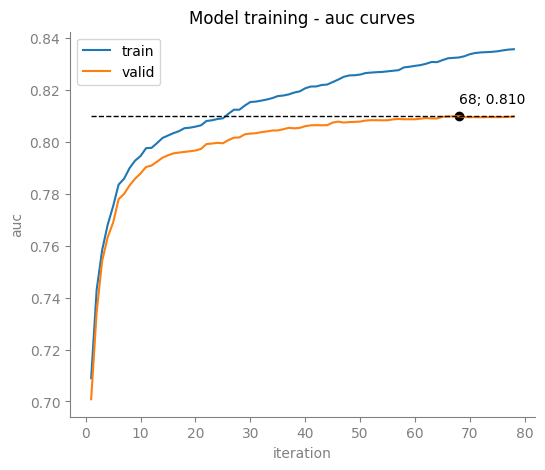

In [93]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

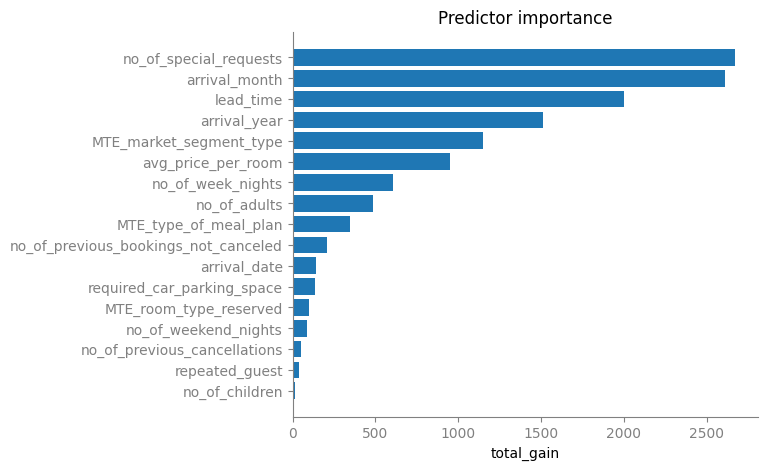

In [95]:
importance_type = 'total_gain'

predictor_strength = sorted([(k, v) for k,v in booster.get_score(importance_type = importance_type).items()], key = lambda x: x[1], reverse = True)
predictor_strength = pd.DataFrame(predictor_strength, columns = ['predictor', 'strength'])

fig = plt.figure(figsize=(6,5))

n_strongest = len(cols_pred)
plt.barh(range(n_strongest, 0, -1), predictor_strength['strength'].iloc[0:20])
plt.yticks(range(n_strongest, 0, -1), predictor_strength['predictor'].iloc[0:20])
plt.xlabel(importance_type)
plt.title('Predictor importance')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()

# Tento

In [274]:
#Removing least important predictor)
cols_pred.remove("no_of_children")
cols_pred.remove("arrival_date")
cols_pred.remove("no_of_previous_cancellations")
cols_pred.remove("repeated_guest")
cols_pred.remove("required_car_parking_space")
#cols_pred.remove("MTE_room_type_reserved")

In [575]:
#Nevsimat si

#mean_lead_time=data[train_mask].loc[data[train_mask]['lead_time'].between(0,180), 'lead_time'].mean(skipna=True)
#mean_lead_time

In [288]:
cols_pred

['no_of_adults',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'MTE_type_of_meal_plan',
 'MTE_room_type_reserved',
 'MTE_market_segment_type']

In [287]:
#data.avg_price_per_room.value_counts(dropna=False)

In [283]:
#mean_avg_price_per_room=data.avg_price_per_room.mean(skipna=True)
#mean_avg_price_per_room
#data['avg_price_per_room'] = data.avg_price_per_room.fillna(value=mean_avg_price_per_room)

In [284]:
#rep=data[train_mask].copy().avg_price_per_room.fillna(value=mean_avg_price_per_room)
#rep=rep.tolist()
#help=data[train_mask].copy()
#help['avg_price_per_room'] = rep
#data[train_mask] = help

In [285]:
#data[train_mask].avg_price_per_room.value_counts(dropna=False)

In [275]:
booster_sklearn = xgb.XGBClassifier(
    booster='gbtree',
    objective='binary:logistic',
    random_state=12,
    max_depth=6,
    eval_metric=['auc'],
    gamma=0.3,
    verbosity=1,
    use_label_encoder=False,
    early_stopping_rounds=10,
    eta=0.2
)

booster_sklearn.fit(
    data[train_mask][cols_pred].values, 
    data[train_mask][col_target].astype(int).values,
    eval_set=[
        (data[train_mask][cols_pred].values, data[train_mask][col_target].values),
        (data[test_mask][cols_pred].values, data[test_mask][col_target].values),
        (data[valid_mask][cols_pred].values, data[valid_mask][col_target].values),
    ],
    verbose=True,
)

[0]	validation_0-auc:0.75526	validation_1-auc:0.75928	validation_2-auc:0.74741
[1]	validation_0-auc:0.77062	validation_1-auc:0.76990	validation_2-auc:0.76183
[2]	validation_0-auc:0.78132	validation_1-auc:0.77831	validation_2-auc:0.77105
[3]	validation_0-auc:0.78561	validation_1-auc:0.78298	validation_2-auc:0.77471
[4]	validation_0-auc:0.78881	validation_1-auc:0.78677	validation_2-auc:0.77757
[5]	validation_0-auc:0.79341	validation_1-auc:0.78997	validation_2-auc:0.78295
[6]	validation_0-auc:0.79753	validation_1-auc:0.79317	validation_2-auc:0.78555
[7]	validation_0-auc:0.80287	validation_1-auc:0.79707	validation_2-auc:0.78931
[8]	validation_0-auc:0.80430	validation_1-auc:0.79767	validation_2-auc:0.79075
[9]	validation_0-auc:0.80509	validation_1-auc:0.79788	validation_2-auc:0.79165
[10]	validation_0-auc:0.80952	validation_1-auc:0.79977	validation_2-auc:0.79524
[11]	validation_0-auc:0.81121	validation_1-auc:0.80164	validation_2-auc:0.79667
[12]	validation_0-auc:0.81341	validation_1-auc:0.8

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eta=0.2, eval_metric=['auc'],
              feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

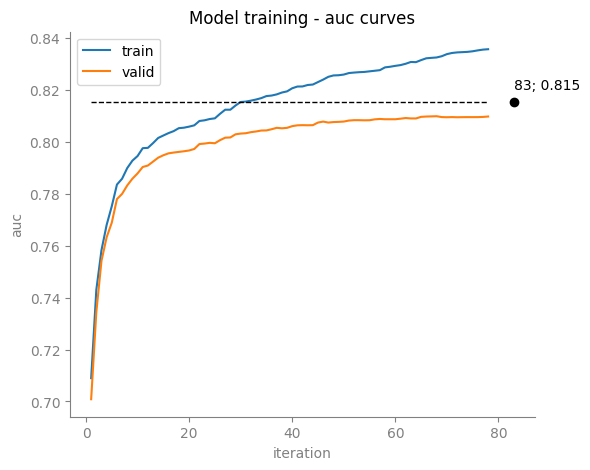

In [276]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster_sklearn.best_score
best_iteration = booster_sklearn.best_iteration+1

ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

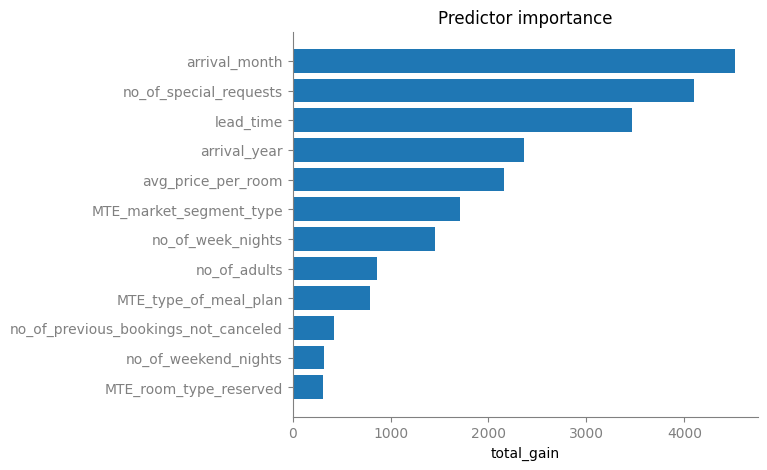

In [277]:
importance_type = 'total_gain'

orig_feature_names = cols_pred
booster_sklearn.get_booster().feature_names = orig_feature_names

predictor_strength = sorted([(k, v) for k,v in booster_sklearn.get_booster().get_score(importance_type = importance_type).items()], key = lambda x: x[1], reverse = True)
predictor_strength = pd.DataFrame(predictor_strength, columns = ['predictor', 'strength'])

fig = plt.figure(figsize=(6,5))

n_strongest = len(cols_pred)

plt.barh(range(n_strongest, 0, -1), predictor_strength['strength'].iloc[0:20])
plt.yticks(range(n_strongest, 0, -1), predictor_strength['predictor'].iloc[0:20])
plt.xlabel(importance_type)
plt.title('Predictor importance')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()

In [286]:
cols_pred

['no_of_adults',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'MTE_type_of_meal_plan',
 'MTE_room_type_reserved',
 'MTE_market_segment_type']

# potialto

In [70]:
def marginal_dependence(data, predictor, bins, col_target):
    dt = data.copy()
    dt[predictor + 'bin'] = pd.qcut(dt.rank(method='first')[predictor], bins).copy() #pd.qcut(df.rank(method='first'), nbins)
    dt.groupby(predictor + 'bin', observed=False).agg(
        def_prob=(col_target, np.mean)
    ).plot(figsize=(9, 6))

C:\Users\matej\AppData\Local\Temp\ipykernel_56116\3003329733.py:4: FutureWarning: The provided callable <function mean at 0x0000017883E90040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dt.groupby(predictor + 'bin', observed=False).agg(


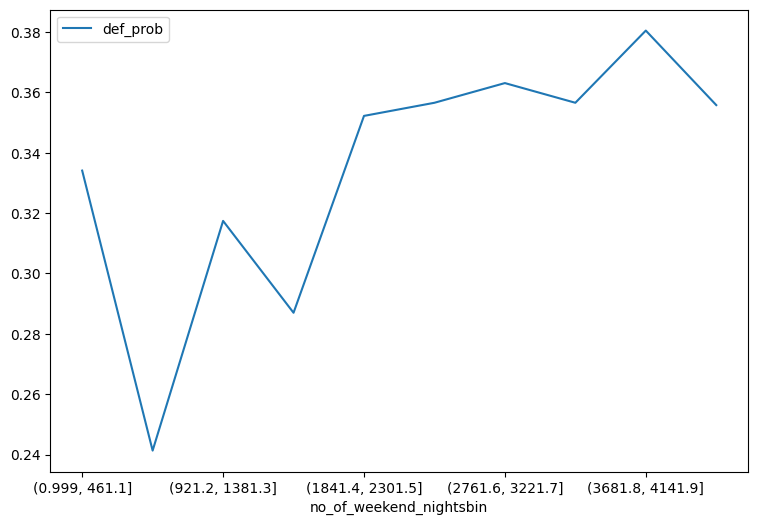

In [71]:
marginal_dependence(data[train_mask], 'no_of_weekend_nights', 10, col_target)

In [279]:
test['predicted_pd'] = booster_sklearn.get_booster().predict(xgb.DMatrix(test[cols_pred]), iteration_range=(0,booster_sklearn.best_iteration))
test['predicted_score'] = np.log(test['predicted_pd'] / (1 - test['predicted_pd']))

In [105]:
def plot_score_calibration(dt, col_score, col_target, n_bins = 25):
    min_score = dt[col_score].min() - 0.1
    max_score = dt[col_score].max() + 0.1
    
    bins = [round(min_score + i * (max_score - min_score) / n_bins, 2) for i in range(n_bins+1)]
    dt = dt.assign(score_bin = pd.cut(dt[col_score], bins = bins, include_lowest = False))
    
    dt_grp = dt.groupby('score_bin', observed=False).agg(
        bad_cnt = (col_target, 'sum'),
        tot_cnt = (col_target, len),
        def_rt = (col_target, 'mean'),
        avg_score = (col_score, 'mean')
    )
    dt_grp['good_cnt'] = dt_grp['tot_cnt'] - dt_grp['bad_cnt']
    dt_grp['bad_cnt_norm'] = dt_grp['bad_cnt'] / dt_grp['tot_cnt']
    dt_grp['good_cnt_norm'] = dt_grp['good_cnt'] / dt_grp['tot_cnt']
    dt_grp['expected_pd'] = 1 / (1 + np.exp(-dt_grp['avg_score']))
    
    fig, axs = plt.subplots(1,2, figsize = (12,4))
    fig.suptitle(col_score)
    plt.subplots_adjust(wspace = 0.4)
    axs[0].bar(range(len(dt_grp)), dt_grp['bad_cnt'], color = 'salmon', label = 'bads')
    axs[0].bar(range(len(dt_grp)), dt_grp['good_cnt'], bottom = dt_grp['bad_cnt'], color = 'lightblue', label = 'goods')
    axs[0].set_ylabel('observations count')
    axs[0].set_xlabel('score')
    axs[0].set_xticks(range(len(dt_grp)))
    axs[0].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[0].spines['right'].set_color('gray')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_color('gray')
    axs[0].spines['bottom'].set_color('gray')
    axs[0].tick_params(axis='y', colors='gray')
    axs[0].tick_params(axis='x', colors='gray')
    
    ax0l = axs[0].twinx()
    ax0l.plot(range(len(dt_grp)), dt_grp['def_rt'], marker = 'o', color = 'red')
    ax0l.plot(range(len(dt_grp)), dt_grp['expected_pd'], color = 'black', ls = '--')
    ax0l.set_ylabel('default rate', color = 'red')
    
    ax0l.spines['right'].set_color('gray')
    ax0l.spines['top'].set_visible(False)
    ax0l.spines['left'].set_color('gray')
    ax0l.spines['bottom'].set_color('gray')
    ax0l.tick_params(axis='y', colors='gray')
    ax0l.tick_params(axis='x', colors='gray')
    
    axs[1].bar(range(len(dt_grp)), dt_grp['bad_cnt_norm'], color = 'salmon', label = 'bads')
    axs[1].bar(range(len(dt_grp)), dt_grp['good_cnt_norm'], bottom = dt_grp['bad_cnt_norm'], color = 'lightblue', label = 'goods')
    axs[1].set_ylabel('frequency')
    axs[1].set_xlabel('score')
    axs[1].set_xticks(range(len(dt_grp)))
    axs[1].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_color('gray')
    axs[1].spines['bottom'].set_color('gray')
    axs[1].tick_params(axis='y', colors='gray')
    axs[1].tick_params(axis='x', colors='gray')

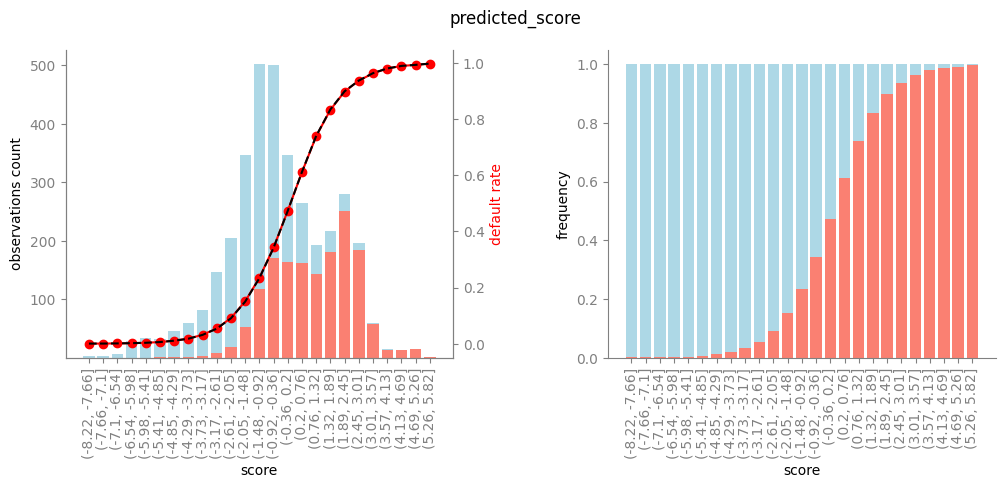

In [107]:
plot_score_calibration(test, 'predicted_score', 'predicted_pd')

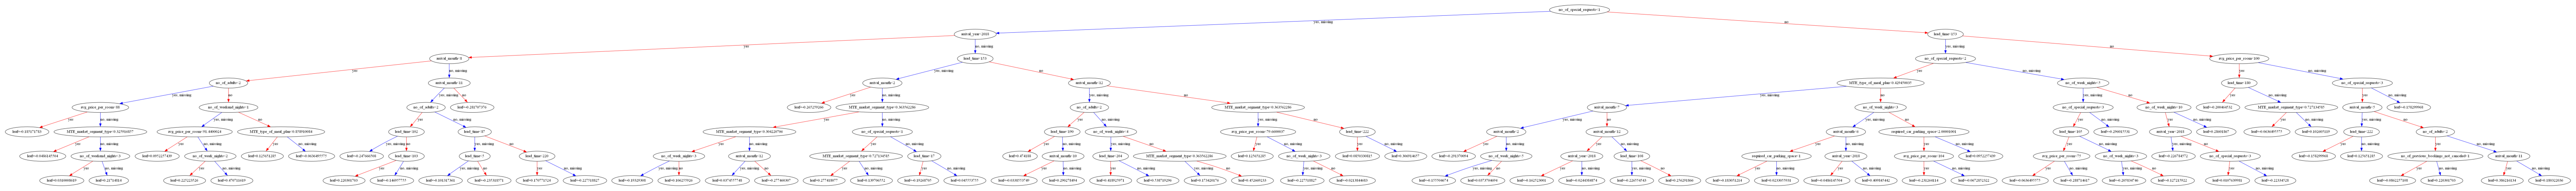

In [136]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin' #treba nastavit svoj priecinok kde je nainstalovany graphviz...dolezity je potom bin

from xgboost import plot_tree
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 80,50

plot_tree(booster_sklearn, num_trees = 0)
plt.show()

rcParams['figure.figsize'] = 5,5

In [280]:
test['predicted_pd']

Booking_ID
INN04969    0.001564
INN34541    0.178885
INN36109    0.132612
INN01554    0.759186
INN24975    0.180533
              ...   
INN29523    0.029965
INN25061    0.390071
INN08475    0.972312
INN13558    0.014278
INN00626    0.153960
Name: predicted_pd, Length: 3593, dtype: float32

In [281]:
test['booking_status']=test['predicted_pd']

In [184]:
test

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,MTE_type_of_meal_plan,MTE_room_type_reserved,MTE_market_segment_type,predicted_pd,predicted_score,booking_status
Booking_ID,,,,,,,,,,,,,,,,,,,,,,,
INN04969,2.0,NaN,1.0,0.0,Meal Plan 1,NaN,NaN,NaN,2017.0,8.0,23.0,NaN,NaN,0.0,NaN,NaN,3.0,0.314747,NaN,NaN,0.002271,-6.085302,0.002271
INN34541,2.0,0.0,NaN,2.0,Meal Plan 1,0.0,NaN,NaN,2018.0,2.0,NaN,Offline,NaN,0.0,0.0,NaN,NaN,0.314747,NaN,0.304221,0.142008,-1.798715,0.142008
INN36109,2.0,NaN,NaN,2.0,Meal Plan 1,0.0,NaN,NaN,2018.0,12.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.314747,NaN,NaN,0.161217,-1.649203,0.161217
INN01554,2.0,NaN,0.0,3.0,NaN,0.0,NaN,NaN,2018.0,6.0,21.0,Online,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.363562,0.768470,1.199694,0.768470
INN24975,2.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2018.0,9.0,NaN,NaN,NaN,0.0,NaN,NaN,2.0,NaN,NaN,NaN,0.195130,-1.417013,0.195130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INN29523,1.0,NaN,NaN,2.0,Meal Plan 2,0.0,Room_Type 1,39.0,2017.0,8.0,NaN,Offline,NaN,0.0,NaN,87.00,NaN,0.429450,0.323375,0.304221,0.018405,-3.976571,0.018405
INN25061,2.0,NaN,1.0,NaN,Not Selected,0.0,NaN,NaN,2018.0,6.0,NaN,Online,0.0,0.0,NaN,NaN,NaN,0.328849,NaN,0.363562,0.363129,-0.561808,0.363129
INN08475,2.0,NaN,NaN,NaN,NaN,NaN,NaN,308.0,2018.0,11.0,NaN,Online,NaN,0.0,0.0,78.30,NaN,NaN,NaN,0.363562,0.965656,3.336380,0.965656


In [282]:
test['booking_status'].to_csv('eval.csv')